In [53]:
import os

download_name = "reviews_with_splits_lite.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/lectures/p02/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()
        
name = "reviews_with_splits_lite.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))  

# YELP Classify

In [54]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [55]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self): 
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

    def __len__(self):
        return len(self._token_to_idx)


vocab = Vocabulary()

vocab.add_token("john")
vocab.add_token("john")
vocab.add_token("ann")

vocab.lookup_token("john"), vocab.lookup_index(2)


(1, 'ann')

In [56]:
class ReviewVectorizer(object):
    def __init__(self, review_vocab, rating_vocab):
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

review_vocab = Vocabulary()
review_vocab.add_many("john has been there . but he is not john .".split())

rating_vocab = Vocabulary(add_unk=False)
rating_vocab.add_many(["positive", "negative"])

vectorizer = ReviewVectorizer(review_vocab, rating_vocab)
vectorizer.vectorize("but john has not been he .")

array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1.], dtype=float32)

### Read Dataset

In [57]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': self.train_df,
                             'val': self.val_df,
                             'test': self.test_df}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_df)

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        review_vector = self._vectorizer.vectorize(row.review)

        rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [58]:

args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='reviews_with_splits_lite.csv',
    save_dir='',
    vectorizer_file='vectorizer.json',
    
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [59]:
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()

In [60]:

vectorizer.review_vocab
len(vectorizer.review_vocab)

7326

In [61]:
dataloader = DataLoader(dataset=dataset)

x_data = []
y_target = []

i = 0
for item in tqdm(dataloader):
    x_data.append(item["x_data"].squeeze())
    y_target.append(item["y_target"].squeeze())

    
x_data = torch.stack(x_data)
y_target = torch.stack(y_target)


  0%|          | 0/39200 [00:00<?, ?it/s]

## Plot data

In [62]:
from sklearn import decomposition
import matplotlib.pyplot as plt

In [63]:
pca = decomposition.PCA(n_components=2)
pca.fit(x_data)
X = pca.transform(x_data)

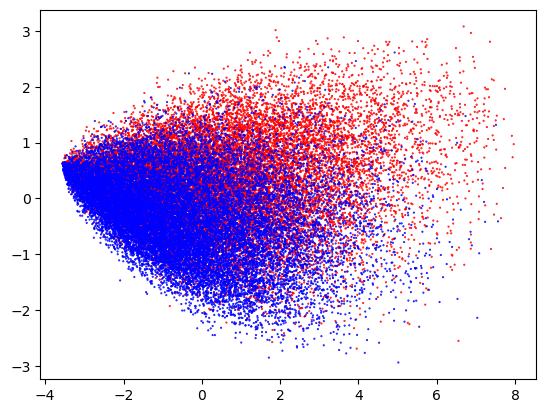

In [64]:
colors = ["red" if y_i == 0 else "blue" for y_i in y_target]


plt.scatter(X[:,0], X[:,1], marker=".", s=1, c=colors)


### Model Classifier

In [65]:
class ReviewClassifier(nn.Module):

    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out


### Initialization

In [66]:
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

args.device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
classifier = classifier.to(args.device)

# Training

In [67]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

train_data = []
valid_data = []

for epoch_index in range(args.num_epochs):
    # TRAIN
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            train_data.append((epoch_index, batch_index, loss_t, running_loss)) 

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
    
    print(f"Train epoch: {epoch_index+1}/{args.num_epochs} loss: {running_loss:.3f} acc: {running_acc:.3f}")            

    # VAL
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)
        
        valid_data.append((epoch_index, batch_index, loss_t, running_loss)) 
        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)
        
    print(f"Valid epoch: {epoch_index+1}/{args.num_epochs} loss: {running_loss:.3f} acc: {running_acc:.3f}")                 
    scheduler.step(running_loss)
    new_lr = optimizer.param_groups[0]["lr"]
    print(f"New lr: {new_lr:.10f}")



Train epoch: 1/100 loss: 0.480 acc: 83.954
Valid epoch: 1/100 loss: 0.382 acc: 88.233
New lr: 0.0010000000
Train epoch: 2/100 loss: 0.331 acc: 90.074
Valid epoch: 2/100 loss: 0.310 acc: 90.433
New lr: 0.0010000000
Train epoch: 3/100 loss: 0.276 acc: 91.628
Valid epoch: 3/100 loss: 0.275 acc: 91.130
New lr: 0.0010000000
Train epoch: 4/100 loss: 0.246 acc: 92.231
Valid epoch: 4/100 loss: 0.254 acc: 91.683
New lr: 0.0010000000
Train epoch: 5/100 loss: 0.226 acc: 92.703
Valid epoch: 5/100 loss: 0.240 acc: 91.923
New lr: 0.0010000000
Train epoch: 6/100 loss: 0.211 acc: 93.043
Valid epoch: 6/100 loss: 0.231 acc: 92.127
New lr: 0.0010000000
Train epoch: 7/100 loss: 0.199 acc: 93.403
Valid epoch: 7/100 loss: 0.224 acc: 92.224
New lr: 0.0010000000
Train epoch: 8/100 loss: 0.190 acc: 93.589
Valid epoch: 8/100 loss: 0.219 acc: 92.175
New lr: 0.0010000000
Train epoch: 9/100 loss: 0.182 acc: 93.834
Valid epoch: 9/100 loss: 0.215 acc: 92.187
New lr: 0.0010000000
Train epoch: 10/100 loss: 0.176 acc: 

Text(0.5, 1.0, 'Losses for first 10 epochs')

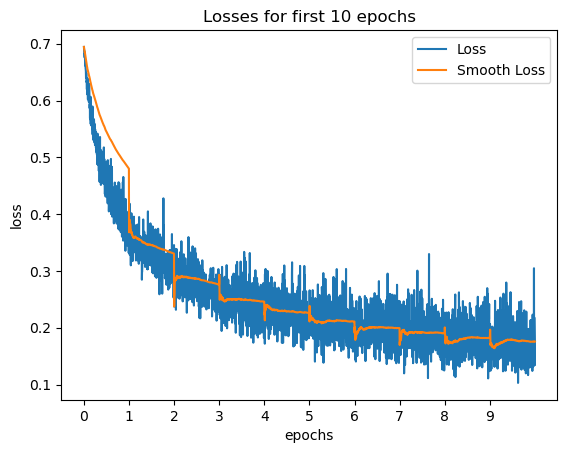

In [68]:
loss_df = pd.DataFrame(train_data, columns=["epoch", "batch", "loss", "running_loss"])
loss_10_epoch = loss_df[loss_df.epoch < 10]

plt.xlabel("epochs")
plt.ylabel("loss")

dataset.set_split('train')
num_batches = dataset.get_num_batches(args.batch_size)
xticks = np.arange(0, len(loss_10_epoch), num_batches)
plt.xticks(xticks, labels=range(len(xticks)))
plt.plot(loss_10_epoch.loss, label="Loss")
plt.plot(loss_10_epoch.running_loss, label="Smooth Loss")
plt.legend()

plt.title("Losses for first 10 epochs")




# Test

In [69]:
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print(f"Test loss: {running_loss} acc: {running_acc}") 

Test loss: 0.21494895116640977 acc: 91.95913461538463


# Inference

In [70]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    review = preprocess_text(review)
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1).to(args.device))

    probability_value = torch.sigmoid(result).item()

    index =  1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

test_review = "this is a pretty awesome notebook"
prediction = predict_rating(test_review, classifier, vectorizer)
print(f"{test_review} -> {prediction}")


this is a pretty awesome notebook -> positive


# Interpretability

In [71]:
fc1_weights = classifier.fc1.weight.cpu().detach()[0]
weights, indices = torch.sort(fc1_weights, dim=0, descending=True)

indices = indices.numpy().tolist()


# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))


Influential words in Positive Reviews:
--------------------------------------
delicious
pleasantly
fantastic
amazing
vegas
great
yum
excellent
ngreat
perfect
awesome
yummy
bomb
love
chinatown
solid
notch
hooked
deliciousness
pleased
====



Influential words in Negative Reviews:
--------------------------------------
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
overpriced
disgusting
unacceptable
slowest
unfriendly
poorly
nmaybe
disappointment
downhill
disappointing
underwhelmed
